In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull as pp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

# Experimental Data

,dataset,construct,model
0,u5,u5,push


11139 / 11139


WT_anti_exp   ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                 
u5      0      2117.604004   3193.407715    382.638794          0.119821
        1      3355.811523   1250.690674    421.813385          0.337264
        2       293.095856   1082.340820    103.340118          0.095478
        3       697.659241    359.168457    119.973557          0.334031
        4        68.759560   3266.139404     19.770317          0.006053
...                    ...           ...           ...               ...
        11134  1806.686157   1463.092285    131.626053          0.089964
        11135   612.322571    419.182312    207.682404          0.495446
        11136  5428.078125  12848.132812    827.460632          0.064403
        11137  1726.100220   1722.536743    180.270187          0.104654
        11138  1376.891113    942.543579     65.136810          0.069107

[11139 rows x 4 columns]

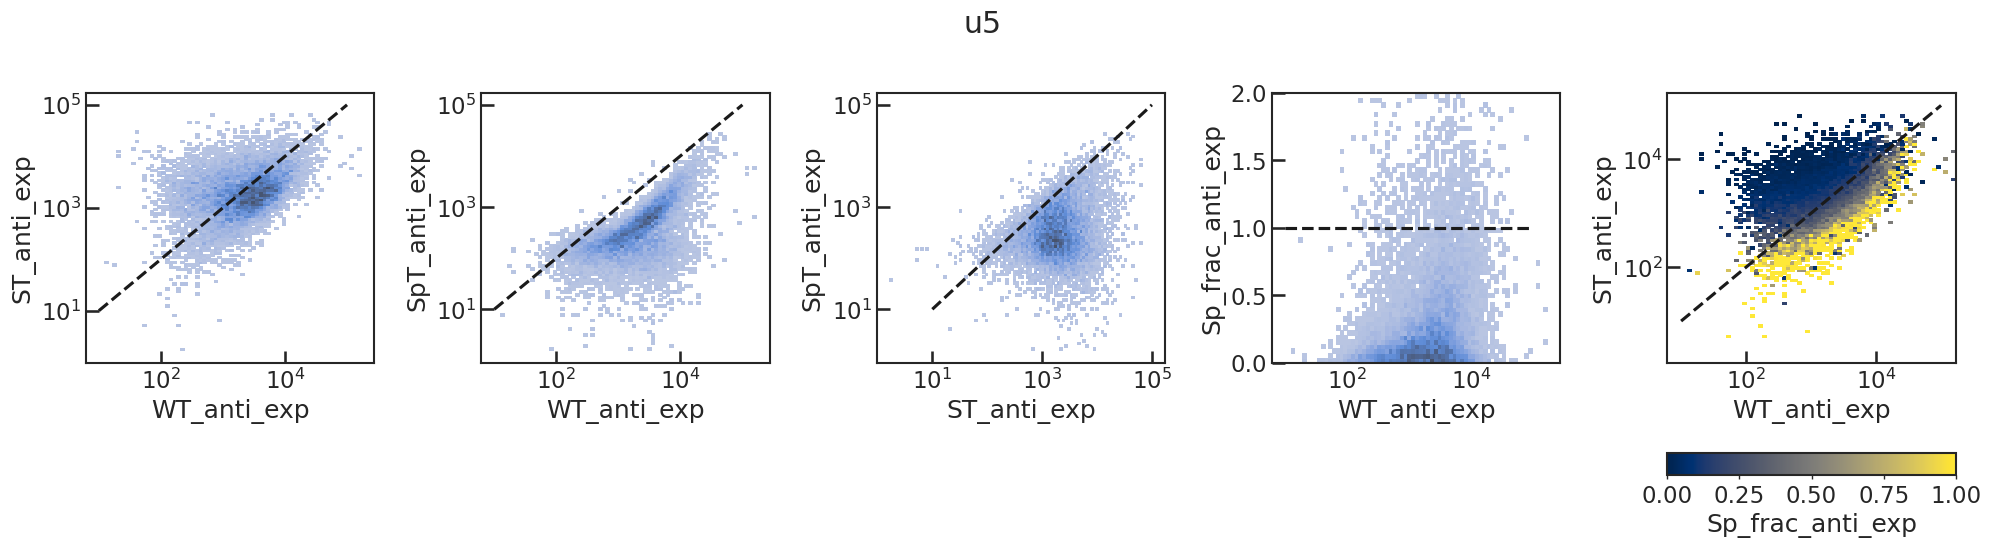

In [2]:


# dataset, construct, model
s_list = [
    ['u5', 'u5', 'push'],
         ]

df_info = pd.DataFrame(s_list, columns=['dataset', 'construct', 'model'])
     
display(df_info)

df_list = []
for index, row in df_info.iterrows():
    df = pd.read_csv("../data/push_data/{}.csv".format(row['dataset']))    
    df['dataset'] = row['dataset']    
    df_list.append(df)
    
    
df = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')


df.set_index("dataset", inplace=True, append=True)
df = df.reorder_levels(df.index.names[::-1])


df = df[(df[df.columns[:-1]] > 0).all(axis=1)].rename(columns={'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp'})

df['Sp_frac_anti_exp'] = df['SpT_anti_exp'] / df['ST_anti_exp']


print(len(df.index), "/", len(df.index))

display(df)


for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4.5))

    
    fig.suptitle(construct)
    
    ax = axes[0]
    
    sns.histplot(group, x='WT_anti_exp', y='ST_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[1]
    
    sns.histplot(group, x='WT_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    
    ax = axes[2]
    
    sns.histplot(group, x='ST_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[3]
        
    
    sns.histplot(group, x='WT_anti_exp', y='Sp_frac_anti_exp', 
                 log_scale=(True, False), ax=ax)
    
    ax.hlines(1e0, xmin=1e1, xmax=1e5, color='k', ls='--')
        
    ax.set_ylim(0, 2.0)
    
    
    ax = axes[4]
    
    df_tmp = df.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
        
    
    
    plt.tight_layout()
    
    
    
    bbox = ax.get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")

    

    plt.show()
    
    


#  Theoretical Model

Three fit parameters:
- Background phosphorylation rate $v_{bg}^p$
- Kinase phosphorylation rate $v_{WS}^p$
- Kinase-Substrate binding affinity $\alpha_{WS}$ [units of concentration]

Fraction of phosphorylated substrate:

$\frac{[S^p_T]}{[S_T]} = \frac{v_{WS}^pp(WS^u) + v_{bg}^p}{v_{WS}^pp(WS^u) + v_{bg}^p + 1}$

Fraction of unphosphorylated substrate bound to writer:

$p(WS^u) = \frac{\frac{[W]}{\alpha_{WS}}}{1 + \frac{[W]}{\alpha_{WS}}}$

The total free substrate and writer can then be found by solving the equations:

$\frac{[W]}{[W_T]} = \frac{1}{1+\frac{[S_f]}{\alpha_{WS}}}$, $\frac{[S_f]}{[S_T]} = \frac{1}{1+\frac{[W]}{\alpha_{WS}}}$



/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


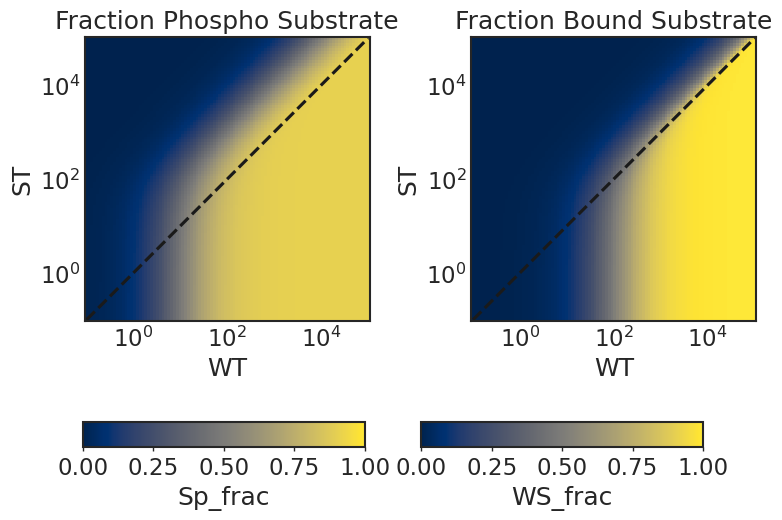

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5)) 

ax = ax1

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([0.0, 1e1, 1e2]))[:, 0]

Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')

bbox = ax.get_position()

cax = fig.add_axes([bbox.x0, bbox.y0-0.15, bbox.x1 - bbox.x0, 0.05])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
cbar.set_label(r"Sp_frac")
    
ax.set_title("Fraction Phospho Substrate")

ax.set_aspect('equal')
  
    
    
    
ax = ax2

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

results = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([0.0, 1e1, 1e2]))

WS_anti_infer = results[:, 5] + results[:, 6]

WS_frac_anti_infer = WS_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, WS_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')

bbox = ax.get_position()

cax = fig.add_axes([bbox.x0, bbox.y0-0.15, bbox.x1 - bbox.x0, 0.05])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
cbar.set_label(r"WS_frac")
    
ax.set_title("Fraction Bound Substrate")

ax.set_aspect('equal')

plt.tight_layout()
    
    
plt.show()


# fig, ax = plt.subplots(1,1, figsize=(6, 4))
# WT = np.logspace(-1, 6, 100, base=10)
# ST = np.logspace(-1, 6, 100, base=10)
# results = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array([0.0, 1e1, 1e2]))

# WS_anti_infer = results[:, 5] + results[:, 6]

# WS_frac_anti_infer = WS_anti_infer / ST

# ax.plot(ST, WS_frac_anti_infer)
# ax.set_xscale('log')

# plt.show()

/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


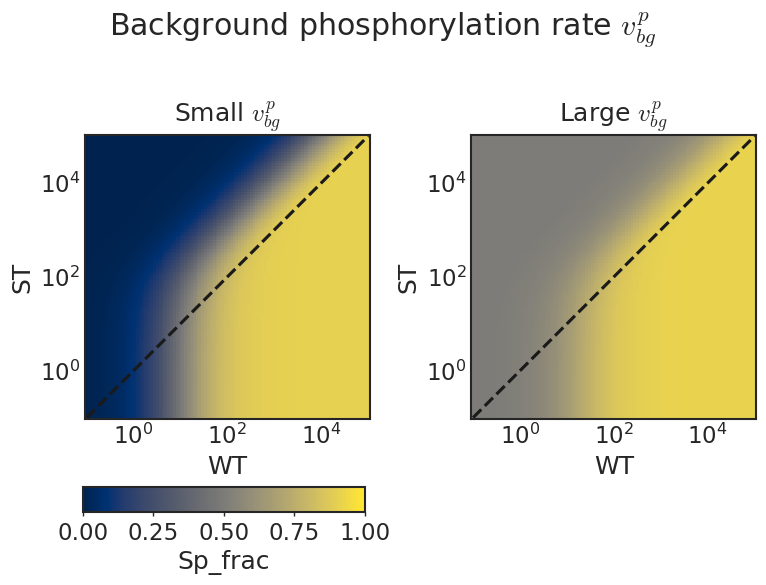

/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


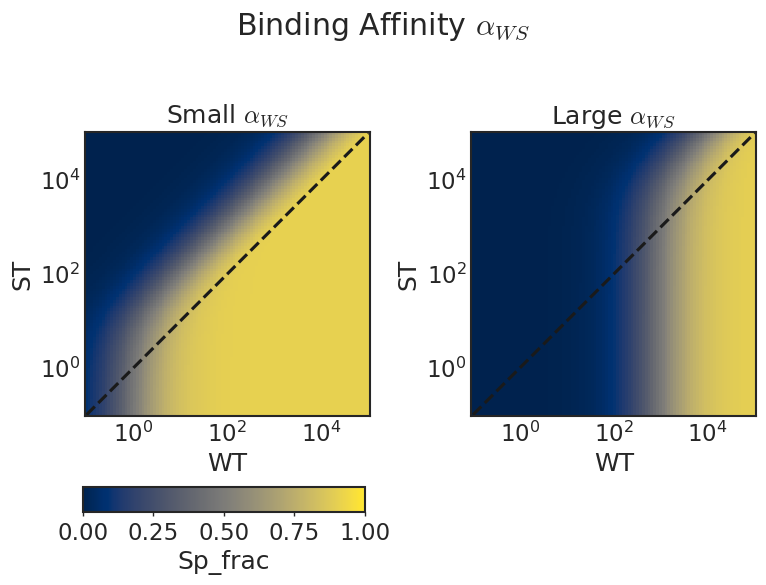

/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


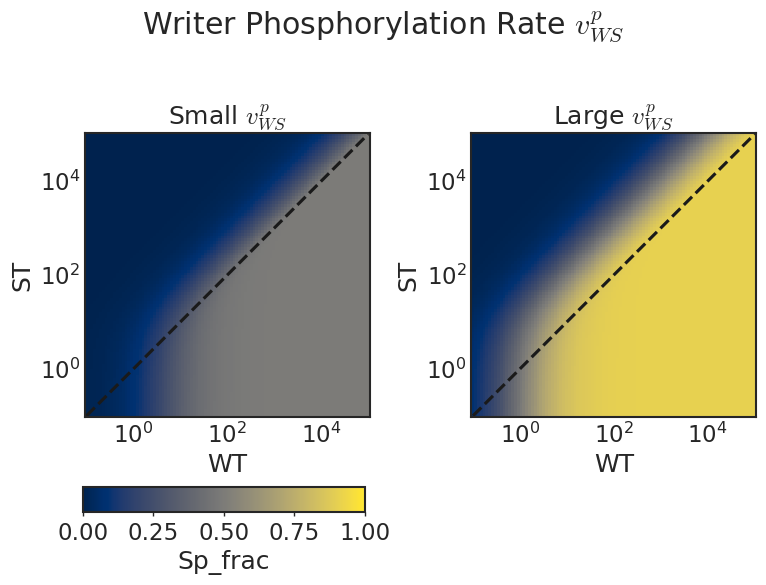

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5)) 

fig.suptitle("Background phosphorylation rate $v^p_{bg}$")

ax = ax1

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([0.0, 1e1, 1e2]))[:, 0]

Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')

bbox = ax.get_position()

cax = fig.add_axes([bbox.x0, bbox.y0-0.15, bbox.x1 - bbox.x0, 0.05])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
cbar.set_label(r"Sp_frac")
    
ax.set_title("Small $v^p_{bg}$")

ax.set_aspect('equal')
    
    
    
ax = ax2

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([1e0, 1e1, 1e2]))[:, 0]

Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')


ax.set_title("Large $v^p_{bg}$")

ax.set_aspect('equal')


plt.tight_layout()

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5)) 

fig.suptitle(r"Binding Affinity $\alpha_{WS}$")

ax = ax1

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([0.0, 1e1, 1e1]))[:, 0]

Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')

bbox = ax.get_position()

cax = fig.add_axes([bbox.x0, bbox.y0-0.15, bbox.x1 - bbox.x0, 0.05])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
cbar.set_label(r"Sp_frac")
    
ax.set_title(r"Small $\alpha_{WS}$")

ax.set_aspect('equal')
    

    
ax = ax2

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([0.0, 1e1, 1e4]))[:, 0]

Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')


ax.set_title(r"Large $\alpha_{WS}$")

ax.set_aspect('equal')


plt.tight_layout()


plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5)) 

fig.suptitle(r"Writer Phosphorylation Rate $v^p_{WS}$")

ax = ax1

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([0.0, 1e0, 1e1]))[:, 0]

Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')

bbox = ax.get_position()

cax = fig.add_axes([bbox.x0, bbox.y0-0.15, bbox.x1 - bbox.x0, 0.05])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
cbar.set_label(r"Sp_frac")
    
ax.set_title(r"Small $v^p_{WS}$")

ax.set_aspect('equal')
    
    
    
ax = ax2

X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))

SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array([0.0, 1e1, 1e1]))[:, 0]

Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()

norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
cmap=plt.cm.cividis

ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')

t = np.linspace(1e-1, 1e5)
ax.plot(t, t, 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('WT')
ax.set_ylabel('ST')


ax.set_title(r"Large $v^p_{WS}$")

ax.set_aspect('equal')


plt.tight_layout()

plt.show()

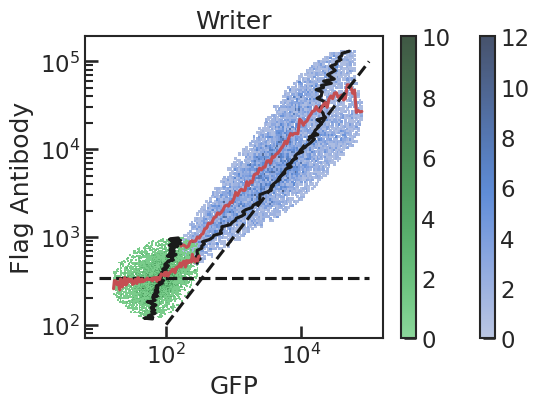

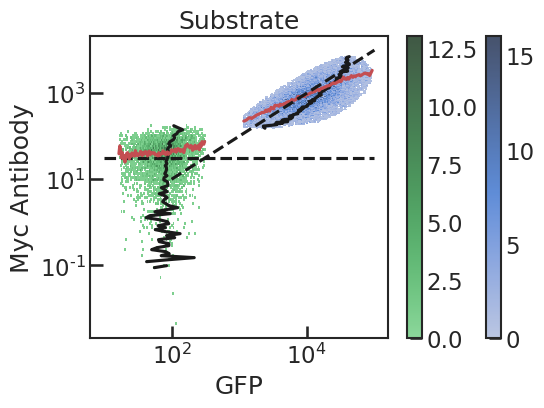

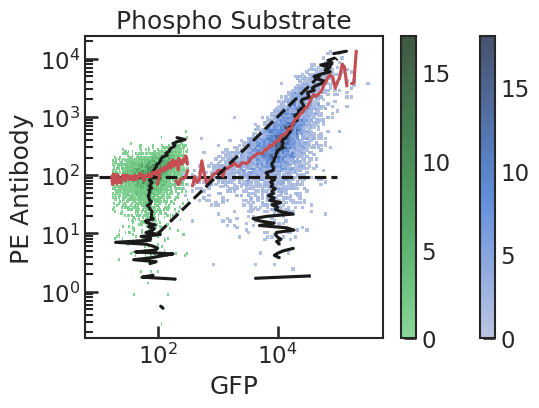

In [5]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.EmpiricalNoise("../data/noise_data/Kinase Noise.csv", 
                                   'Flag Antibody', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_writer_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'Flag Antibody', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
writer_noise.plot(ax)
empty_writer_noise.plot(ax, color='g')
ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.plot(np.logspace(2, 5, base=10), np.logspace(2, 5, base=10), ls='--', color='k')

plt.show()

    
substrate_noise = noise.EmpiricalNoise("../data/noise_data/Substrate Noise.csv", 
                                   'Myc Antibody', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_substrate_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'Myc Antibody', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
substrate_noise.plot(ax)
empty_substrate_noise.plot(ax, color='g')
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.plot(np.logspace(2, 5, base=10), 1e-1*np.logspace(2, 5, base=10), ls='--', color='k')

plt.show()


    
phospho_noise = noise.EmpiricalNoise("../data/noise_data/PE Noise.csv", 
                                   'PE Antibody', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_phospho_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'PE Antibody', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
phospho_noise.plot(ax)
empty_phospho_noise.plot(ax, color='g')
ax.set_title("Phospho Substrate")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.plot(np.logspace(2, 5, base=10), 1e-1*np.logspace(2, 5, base=10), ls='--', color='k')


plt.show()

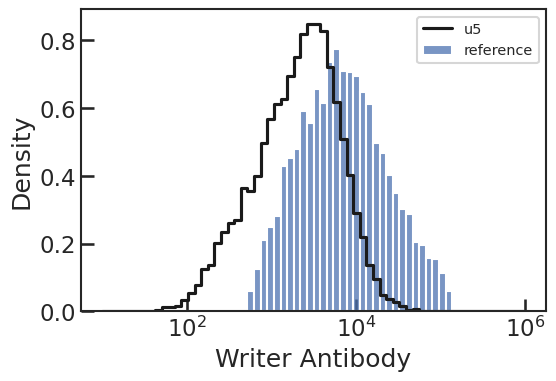

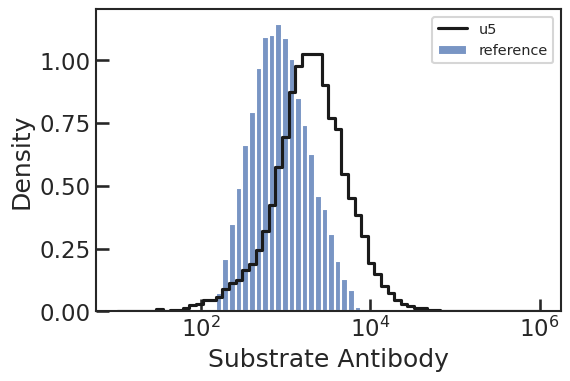

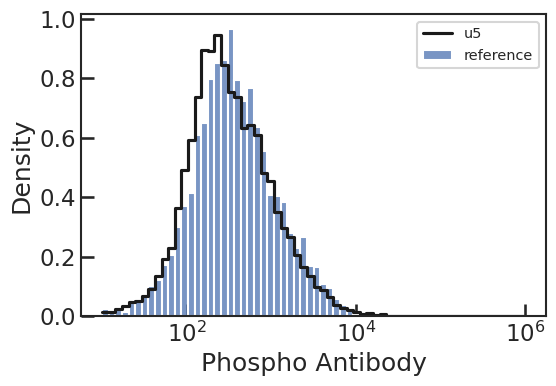

In [6]:

for dataset, group in df.groupby("dataset"):
    
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    sns.histplot(group['WT_anti_exp'], binrange=(1, 6), log_scale=True, bins=64, ax=ax, label=dataset, element='step', fill=False, color='k', stat='density')
    
    sns.histplot(writer_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='reference', color='b', stat='density')
    
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    plt.show()
    
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    sns.histplot(group['ST_anti_exp'], binrange=(1, 6), log_scale=True, bins=64, ax=ax, label=dataset, element='step', fill=False, color='k', stat='density')
    
    sns.histplot(substrate_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='reference', color='b', stat='density')
    
    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    plt.show()

    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    sns.histplot(group['SpT_anti_exp'], binrange=(1, 6), log_scale=True, bins=64, ax=ax, label=dataset, element='step', fill=False, color='k', stat='density')
    
    sns.histplot(phospho_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='reference', color='b', stat='density')
    
    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    plt.show()
    
    



# Questions: 

- How is antibody measurement related to concentration? Scale? Linear? Value at zero concentration?
- How do measurements vary from experiment to experiment?
- How to shift substrate so that fraction is limited between 0 and 1?


# Observations:

- Antibody and GFP measurements are roughtly approximated by linear relationship.
- Flourescent measurements are not zero at zero concentration.
- Overall scale (shift on log axes) seems to change between experiments.


# Example of unit conversion:
Map experiment to noise measurements. Fit fraction of empty cells and overall shift on log axes.

0.0826501578109411 [ 0.1951854  -0.39631204]
0.07901151989099775 [ 0.19412635 -0.41789745]
0.0638384253756279 [ 0.14084239 -0.47839567]
0.06067748926525729 [ 0.13003397 -0.4735936 ]
0.060665888536794554 [ 0.12829847 -0.47416417]
0.05962649219925731 [ 0.12628072 -0.47730387]
0.0591742610047451 [ 0.12511998 -0.47876123]
0.056788793496370116 [ 0.11715115 -0.48832651]
0.05596441840493199 [ 0.11277617 -0.49342008]
0.05588910235782313 [ 0.11301445 -0.49311521]
0.055885258665944015 [ 0.11319827 -0.49282145]
0.05587787026113178 [ 0.11318412 -0.49275782]
0.05587667213708358 [ 0.11318183 -0.49275575]
      fun: 0.05587666664675833
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.52436466, -0.50787148])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 387
      nit: 13
     njev: 129
   status: 2
  success: False
        x: array([ 0.11318183, -0.49275575])


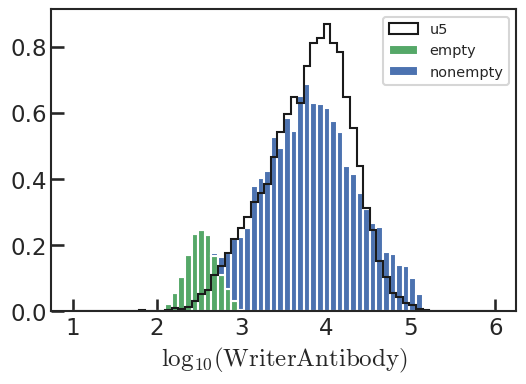

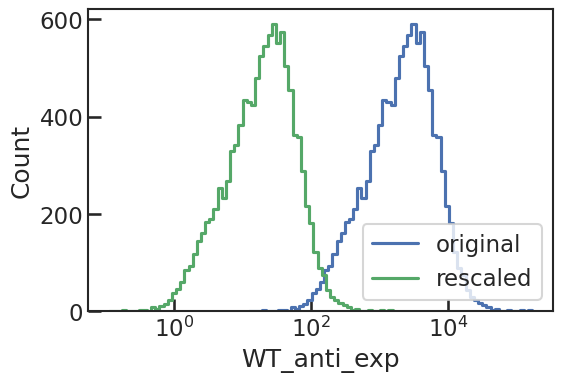

0.06606643220990505 [0.         0.37691462]
0.048785396989146634 [0.03383662 0.33840578]
0.048784475942598826 [0.03382527 0.33835181]
0.048784470476814445 [0.0338252  0.33835149]
      fun: 0.048784470399565016
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.08173485, 0.13624095])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 252
      nit: 4
     njev: 84
   status: 2
  success: False
        x: array([0.0338252 , 0.33835149])


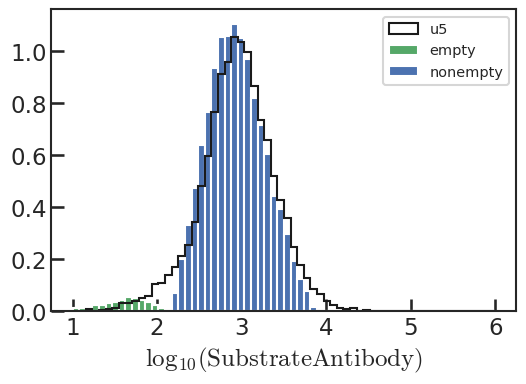

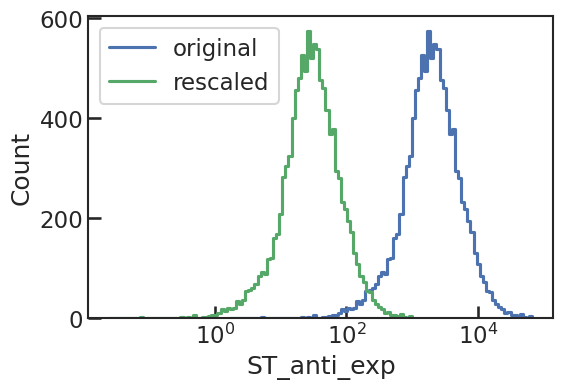

0.02122599739070298 [ 0.03189227 -0.0485299 ]
0.019926590280942125 [ 0.03062554 -0.04701971]
0.019908535149727263 [ 0.03059081 -0.04697342]
0.019907564678862857 [ 0.03058807 -0.04697174]
0.01990755330138344 [ 0.03058804 -0.04697168]
0.019907553205524453 [ 0.03058804 -0.04697168]
      fun: 0.019907553205524453
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.35420163, -0.40560922])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 177
      nit: 6
     njev: 59
   status: 0
  success: True
        x: array([ 0.03058804, -0.04697168])


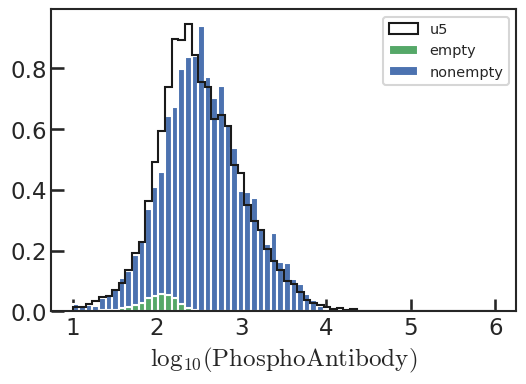

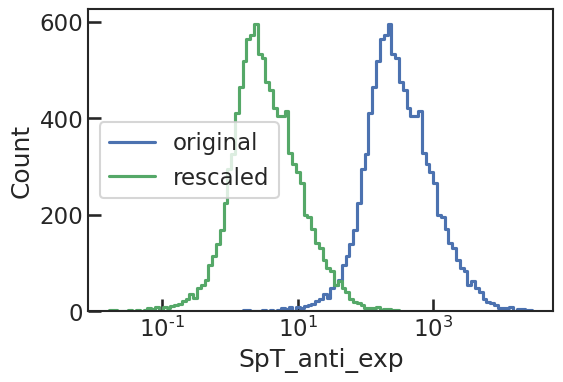

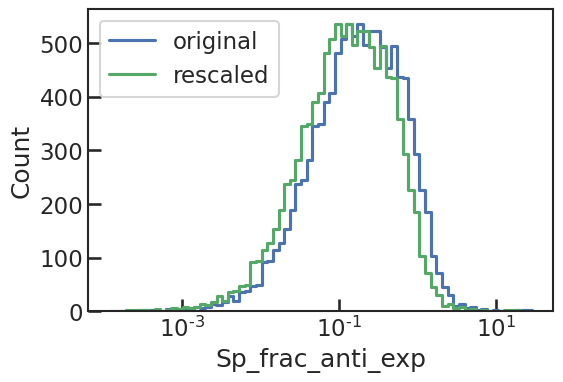

WT_anti_exp   ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp  \
dataset                                                                    
u5      0      2117.604004   3193.407715    382.638794          0.119821   
        1      3355.811523   1250.690674    421.813385          0.337264   
        2       293.095856   1082.340820    103.340118          0.095478   
        3       697.659241    359.168457    119.973557          0.334031   
        4        68.759560   3266.139404     19.770317          0.006053   
...                    ...           ...           ...               ...   
        11134  1806.686157   1463.092285    131.626053          0.089964   
        11135   612.322571    419.182312    207.682404          0.495446   
        11136  5428.078125  12848.132812    827.460632          0.064403   
        11137  1726.100220   1722.536743    180.270187          0.104654   
        11138  1376.891113    942.543579     65.136810          0.069107   

               WT_anti_rescaled  ST_anti_rescaled  SpT_anti_rescaled  \
dataset                                                                
u5      0             19.440068         47.341232           4.081054   
        1             30.807085         18.541083           4.498873   
        2              2.690684         16.045351           1.102179   
        3              6.404665          5.324556           1.279584   
        4              0.631228         48.419455           0.210861   
...                         ...               ...                ...   
        11134         16.585774         21.689868           1.403865   
        11135          5.621255          6.214242           2.215048   
        11136         49.830946        190.469394           8.825325   
        11137         15.845978         25.536048           1.922681   
        11138         12.640162         13.972902           0.694720   

               Sp_frac_anti_rescaled  
dataset                               
u5      0                   0.086205  
        1                   0.242643  
        2                   0.068692  
        3                   0.240318  
        4                   0.004355  
...                              ...  
        11134               0.064724  
        11135               0.356447  
        11136               0.046335  
        11137               0.075293  
        11138               0.049719  

[11139 rows x 8 columns]

In [7]:

for dataset, group in df.groupby("dataset"):
    
    
    (writer_empty_frac, writer_scale) = noise.calc_mixture(group['WT_anti_exp'], empty_writer_noise, writer_noise)
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    hist, edges = np.histogram(np.log10(group['WT_anti_exp']) - writer_scale, range=(1, 6), bins=64)
    norm = np.sum(hist*(edges[1:]-edges[0:len(edges)-1]))
    
    ax.hist(edges[:-1], edges, weights=hist/norm, histtype='step', color='k', label=dataset)
    
    nonempty_hist, edges = np.histogram(np.log10(writer_noise.get_anti()), range=(1, 6), bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_writer_noise.get_anti()), range=(1, 6), bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([edges[:-1], edges[:-1]], edges, weights=[empty_hist/empty_norm*writer_empty_frac, nonempty_hist/nonempty_norm*(1-writer_empty_frac)], histtype='barstacked', 
            color=['g', 'b'], label=['empty', 'nonempty'])
        
    ax.set_xlabel("$\log_{10}(\mathrm{Writer Antibody})$")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    plt.show()
    
    
    df.loc[group.index, 'WT_anti_rescaled'] = group['WT_anti_exp']/10**writer_scale / 10**(np.mean(np.log10(empty_writer_noise.get_anti())))

    ax = sns.histplot(df.loc[group.index, 'WT_anti_exp'], log_scale=True, fill=False, element="step", label='original')
    sns.histplot(df.loc[group.index, 'WT_anti_rescaled'], log_scale=True, ax=ax, color='g', fill=False, element="step", label='rescaled')
    ax.legend()
    plt.show()
    
    
    (substrate_empty_frac, substrate_scale) = noise.calc_mixture(group['ST_anti_exp'], empty_substrate_noise, substrate_noise)
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    hist, edges = np.histogram(np.log10(group['ST_anti_exp']) - substrate_scale, range=(1, 6), bins=64)
    norm = np.sum(hist*(edges[1:]-edges[0:len(edges)-1]))
    
    ax.hist(edges[:-1], edges, weights=hist/norm, histtype='step', color='k', label=dataset)
    
    nonempty_hist, edges = np.histogram(np.log10(substrate_noise.get_anti()), range=(1, 6), bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_substrate_noise.get_anti()), range=(1, 6), bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([edges[:-1], edges[:-1]], edges, weights=[empty_hist/empty_norm*substrate_empty_frac, nonempty_hist/nonempty_norm*(1-substrate_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
        
    ax.set_xlabel("$\log_{10}(\mathrm{Substrate Antibody})$")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    plt.show()
    
    
    threshold = 0.0
    df.loc[group.index, 'ST_anti_rescaled'] = group['ST_anti_exp']/10**substrate_scale / 10**(np.mean(np.log10(empty_substrate_noise.get_anti())))
    
    ax = sns.histplot(df.loc[group.index, 'ST_anti_exp'], log_scale=True, fill=False, element="step", label='original')
    sns.histplot(df.loc[group.index, 'ST_anti_rescaled'], log_scale=True, ax=ax, color='g', fill=False, element="step", label='rescaled')
    ax.legend()
    plt.show()
    
    
    (phospho_empty_frac, phospho_scale) = noise.calc_mixture(group['SpT_anti_exp'], empty_phospho_noise, phospho_noise)
    
    phospho_scale = 0.0
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    hist, edges = np.histogram(np.log10(group['SpT_anti_exp'])-phospho_scale, range=(1, 6), bins=64)
    norm = np.sum(hist*(edges[1:]-edges[0:len(edges)-1]))
    
    ax.hist(edges[:-1], edges, weights=hist/norm, histtype='step', color='k', label=dataset)
    
    nonempty_hist, edges = np.histogram(np.log10(phospho_noise.get_anti()), range=(1, 6), bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_phospho_noise.get_anti()), range=(1, 6), bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([edges[:-1], edges[:-1]], edges, weights=[empty_hist/empty_norm*phospho_empty_frac, nonempty_hist/nonempty_norm*(1-phospho_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
        
    ax.set_xlabel("$\log_{10}(\mathrm{Phospho Antibody})$")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    plt.show()
    
    df.loc[group.index, 'SpT_anti_rescaled'] = group['SpT_anti_exp']/10**phospho_scale / 10**(np.mean(np.log10(empty_phospho_noise.get_anti())))
    

    ax = sns.histplot(df.loc[group.index, 'SpT_anti_exp'], log_scale=True, fill=False, element="step", label='original')
    sns.histplot(df.loc[group.index, 'SpT_anti_rescaled'], log_scale=True, ax=ax, color='g', fill=False, element="step", label='rescaled')
    ax.legend()
    plt.show()
    
    
    df.loc[group.index, 'Sp_frac_anti_rescaled'] = df.loc[group.index, 'SpT_anti_rescaled'] / df.loc[group.index, 'ST_anti_rescaled']
    
    
    
    ax = sns.histplot(df.loc[group.index, 'Sp_frac_anti_exp'], log_scale=True, fill=False, element="step", label='original')
    sns.histplot(df.loc[group.index, 'Sp_frac_anti_rescaled'], log_scale=True, ax=ax, color='g', fill=False, element="step", label='rescaled')
    ax.legend()
    plt.show()
    

display(df)

In [8]:
def solve(df, df_info, param_dict, x0, bounds, verbose=False):

    if verbose:
        start = time.time()

    def func(x):
                        
        loss = 0.0
        
        for index, row in df_info.iterrows():
            dataset = row['dataset']
            
            construct = row['construct']
            
#             noise_params = np.array(x)[param_dict[construct][0:1]]
            model_params = 10**np.array(x)[param_dict[construct][0:]]
            
            df_data = df.query("dataset=='{}'".format(dataset))

            
#             phospho_scale = noise_params[0]

            
            # predict inferred antibody values for phosphorylated substrate
            if row['model'] == 'background':
                 
                df.loc[df_data.index, 'SpT_anti_infer'] = pp.Background().predict_all(df_data[['ST_anti_rescaled']].values, model_params)[:, 0]
            
            if row['model'] == 'push':
                            
                df.loc[df_data.index, 'SpT_anti_infer'] = pp.PushAmp().predict_all(df_data[['WT_anti_rescaled', 'ST_anti_rescaled']].values, model_params)[:, 0]
            
            
#             loss += np.mean((df.loc[df_data.index, 'SpT_anti_infer']*phospho_scale-df.loc[df_data.index, 'SpT_anti_rescaled'])**2/df.loc[df_data.index, 'ST_anti_rescaled']**2)
            
                       
            df.loc[df_data.index, 'Sp_frac_anti_infer'] = df.loc[df_data.index, 'SpT_anti_infer'] / df.loc[df_data.index, 'ST_anti_rescaled']
            
#             df.loc[df_data.index, 'SpT_anti_rescaled'] = 10**(np.log10(group['SpT_anti_exp'])/phospho_scale) / 10**(np.mean(np.log10(empty_phospho_noise.get_anti())))
            
#             df.loc[df_data.index, 'Sp_frac_anti_rescaled'] = df.loc[df_data.index, 'SpT_anti_rescaled'] / df.loc[df_data.index, 'ST_anti_rescaled']
            
#             loss += np.mean((df.loc[df_data.index, 'Sp_frac_anti_infer']-10**(np.log10(df.loc[df_data.index, 'SpT_anti_rescaled'])*0.9)/df.loc[df_data.index, 'ST_anti_rescaled'])**2)
    
            
            loss += np.mean((df.loc[df_data.index, 'Sp_frac_anti_infer']-df.loc[df_data.index, 'Sp_frac_anti_rescaled'])**2)
            
            
        return loss




    print("Initial Loss:", func(x0))

    def callback(x):
        print(func(x), x)

    res = opt.minimize(func, x0, method='L-BFGS-B', 
                       jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-8, 
                                'gtol': 1e-8, 'ftol':1e-12,
                               'finite_diff_rel_step': 1e-2},
                      callback=callback)
    

#     callback = lambda x, f, context: print(f, x, context)
    
#     seed = 43
#     rand.seed(seed)
#     res = opt.dual_annealing(func, bounds, x0=x0, seed=seed, no_local_search=False, callback=callback, maxiter=100)


    print("Final Loss:", res.fun, func(res.x))

    end = time.time()

    print("Time Elapsed", end-start, "seconds")

    print(res)
        
    
    return res

In [9]:
param_dict = {}

param_labels = [r"$\log_{10}(v_{bg}^p)$", r"$\log_{10}(v_{WS}^p)$"]
x0 = [0.0, 0.0]
bounds = [(None, None), (None, None)]
# bounds = [(-3, 1), (-3, 3)]

param_index = 1
for index, row in df_info.iterrows():
    
    construct = row['construct']
    model = row['model']
                
    if construct not in param_dict:
        if model == 'background':
            param_dict[construct] = [0]

        elif model == 'push':
            param_dict[construct] = [0, 1, param_index+1]
            param_index += 1
            
            param_labels.append(construct + ": " + r"$\log_{10}(\alpha_{WS})$")
            x0.append(3.0)
            bounds.append((None, None))
        

print(param_labels)
print(param_dict)

print(x0)
print(bounds)

res = solve(df, df_info, param_dict, x0, bounds, verbose=True)


['$\\log_{10}(v_{bg}^p)$', '$\\log_{10}(v_{WS}^p)$', 'u5: $\\log_{10}(\\alpha_{WS})$']
{'u5': [0, 1, 2]}
[0.0, 0.0, 3.0]
[(None, None), (None, None), (None, None)]
Initial Loss: 0.35140576373853477
0.31166983732926073 [-0.99957423 -0.02215932  3.01898238]
0.2895007870872799 [-0.54649807  0.09557051  2.91294336]
0.28924542179331325 [-0.51017082  0.10992403  2.89923134]
0.2891716570149121 [-0.50714836  0.124321    2.88495481]
0.2888199909143094 [-0.51086228  0.29218449  2.71722107]
0.28851505271905503 [-0.52742239  0.24675106  2.75790201]
0.28816568412039206 [-0.5617894   0.28448715  2.71128774]
0.28790131621367415 [-0.6303601   0.36773849  2.58713549]
0.28772868096365883 [-0.63928731  0.31368107  2.57010832]
0.28758513253393814 [-0.66934715  0.2681958   2.49288517]
0.2858488214960337 [-0.96482264 -0.17781176  1.60394218]
0.28568163539007374 [-0.99879992 -0.21624751  1.50951538]
0.2831895709507887 [-1.29835592 -0.39612383  0.77480369]
0.2766080684399493 [-1.61938626 -0.39337966  0.093886

[7.28464100e-05 6.21067446e-01 4.33339851e-05]


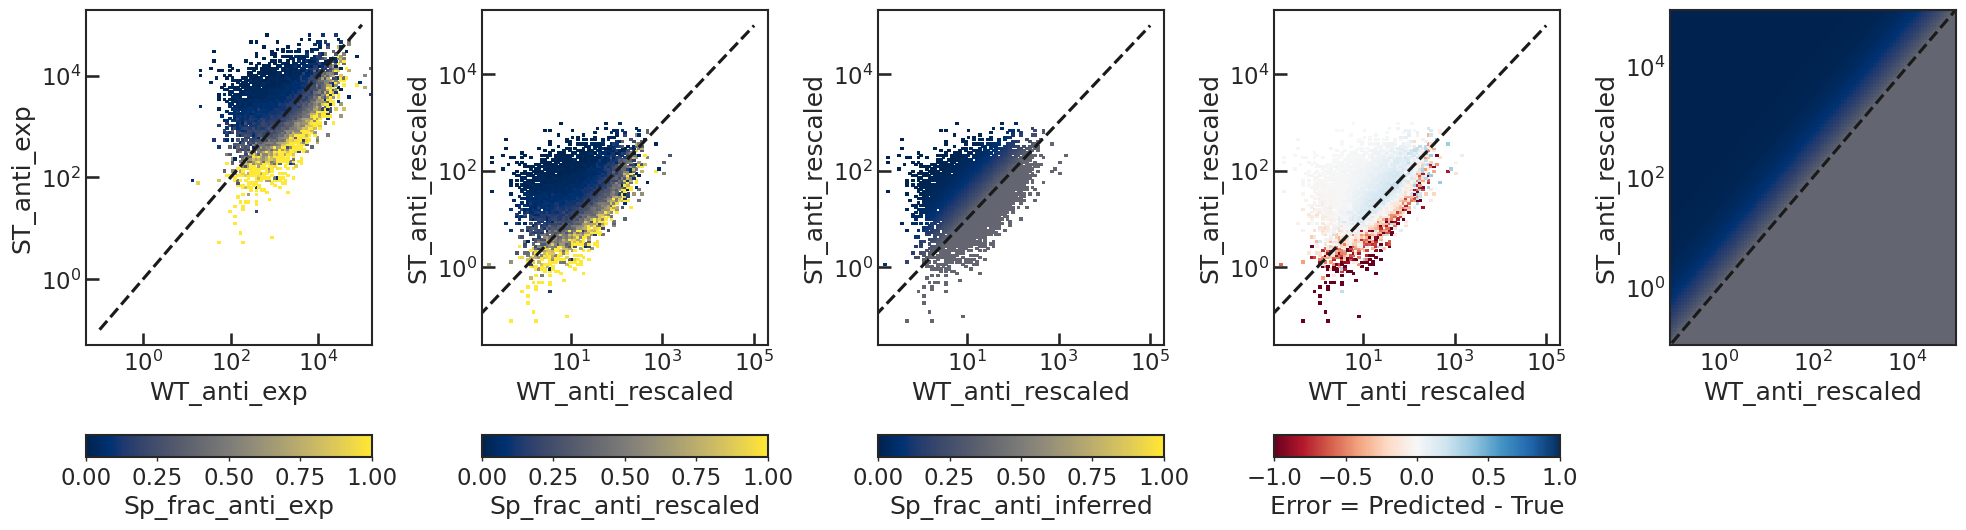

In [10]:



for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    
    
#     phospho_scale = noise_params[0]

    phospho_scale = 1.0
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4.5))
    
    ax = axes[0]
    
    df_tmp = df.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e-1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    
    
    
    
    ax = axes[1]
    
    df_tmp = df.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_rescaled']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_rescaled']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_rescaled'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_rescaled'], yedges, labels=False)
    
    
#     df_tmp['SpT_anti_rescaled'] = 10**(np.log10(df_tmp['SpT_anti_exp'])*phospho_scale) / 10**(np.mean(np.log10(empty_phospho_noise.get_anti())))  
#     df_tmp['Sp_frac_anti_rescaled'] = df_tmp['SpT_anti_rescaled'] / df_tmp['ST_anti_rescaled']
    
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_rescaled'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e-1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_rescaled')
    ax.set_ylabel('ST_anti_rescaled')
        
    
    
    
    
    ax = axes[2]
    
    df_tmp = df.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_rescaled']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_rescaled']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_rescaled'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_rescaled'], yedges, labels=False)

    
    df_tmp['SpT_anti_infer'] = pp.PushAmp().predict_all(df_tmp[['WT_anti_rescaled', 'ST_anti_rescaled']].values, model_params)
    
    df_tmp['Sp_frac_anti_infer'] = df_tmp['SpT_anti_infer'] / df_tmp['ST_anti_rescaled']

    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_infer'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e-1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_rescaled')
    ax.set_ylabel('ST_anti_rescaled')
    
    
    
    
    
    ax = axes[3]
    
    df_tmp = df.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_rescaled']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_rescaled']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_rescaled'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_rescaled'], yedges, labels=False)

#     df_tmp['SpT_anti_rescaled'] = 10**(np.log10(df_tmp['SpT_anti_exp'])*phospho_scale) / 10**(np.mean(np.log10(empty_phospho_noise.get_anti())))  
#     df_tmp['Sp_frac_anti_rescaled'] = df_tmp['SpT_anti_rescaled'] / df_tmp['ST_anti_rescaled']
    
    df_tmp['SpT_anti_infer'] = pp.PushAmp().predict_all(df_tmp[['WT_anti_rescaled', 'ST_anti_rescaled']].values, model_params)
    df_tmp['Sp_frac_anti_infer'] = df_tmp['SpT_anti_infer'] / df_tmp['ST_anti_rescaled']
    
    df_tmp['error'] = df_tmp['Sp_frac_anti_infer'] - df_tmp['Sp_frac_anti_rescaled']
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['error'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
    cmap2=plt.cm.RdBu
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap2, norm=norm2, rasterized=True)
    
    t = np.linspace(1e-1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_rescaled')
    ax.set_ylabel('ST_anti_rescaled')
        
        
    
    
    
    
    ax = axes[4]
    
    X, Y = np.meshgrid(np.logspace(-1, 5, 100, base=10), np.logspace(-1, 5, 100, base=10))
    
    print(model_params)
    
    SpT_anti_infer = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array(model_params))[:, 0]
    
    Sp_frac_anti_infer = SpT_anti_infer / Y.flatten()
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    ax.pcolormesh(X, Y, Sp_frac_anti_infer.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')
    
    t = np.linspace(1e-1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_rescaled')
    ax.set_ylabel('ST_anti_rescaled')
        
    
    
    
        
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_rescaled")
    
    
    bbox = axes[2].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_inferred")
    
    
    bbox = axes[3].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Error = Predicted - True")

    

    plt.show()
    

[7.28464100e-05 6.21067446e-01 4.33339851e-05]


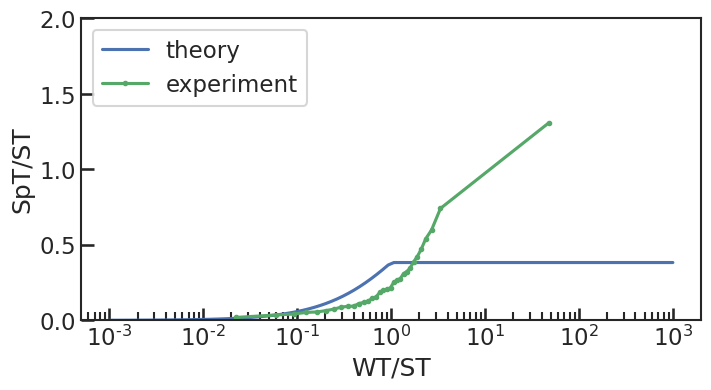

In [11]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)
    
    
#     phospho_scale = noise_params[0]

    phospho_scale = 1.0
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    
    ST = 1e1*np.ones(100)
    WT = np.logspace(-2, 4, 100, base=10)
    
    SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array(model_params))[:, 0]
    
    ax.plot(WT/ST, SpT/ST, 'b', label="theory")
    
    
    
    
    df_tmp = df.copy()
    df['ratio'] = df['WT_anti_rescaled'] / df['ST_anti_rescaled']
    
    bin_labels, edges = pd.qcut(df['ratio'], 32, labels=False, retbins=True)
    
    df['bin'] = bin_labels
    
    Sp_frac = df.groupby('bin')['Sp_frac_anti_rescaled'].mean() 
    
    ax.plot((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, 'g.-', label="experiment", ms=6.0)
    
    ax.set_xscale('log')
    
    ax.set_ylim(0, 2.0)
    
    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST")
    
    ax.legend(loc='upper left')
    
    plt.show()

[7.28464100e-05 6.21067446e-01 4.33339851e-05]


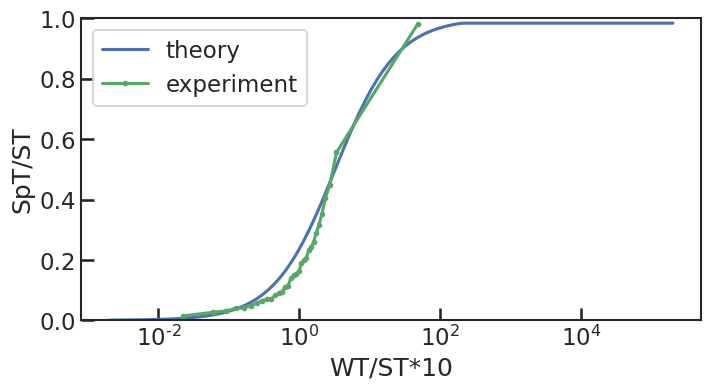

In [12]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)
    
    
#     phospho_scale = noise_params[0]

    phospho_scale = 1.0
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    
    ST = 1e1*np.ones(100)
    WT = np.logspace(-4, 4, 100, base=10)
    
    SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array([7.28464100e-05, 100*6.21067446e-01, 4.33339851e-05]))[:, 0]
    
    ax.plot(WT/ST*2e2, SpT/ST, 'b', label="theory")
    
    
    
    
    df_tmp = df.copy()
    df['ratio'] = df['WT_anti_rescaled'] / df['ST_anti_rescaled']
    
    bin_labels, edges = pd.qcut(df['ratio'], 32, labels=False, retbins=True)
    
    df['bin'] = bin_labels
    
    Sp_frac = df.groupby('bin')['Sp_frac_anti_rescaled'].mean() 
    
    ax.plot((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac*0.75, 'g.-', label="experiment", ms=6.0)
    
    ax.set_xscale('log')
    
    ax.set_ylim(0, 1.0)
    
    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST*10")
    
    ax.legend(loc='upper left')
    
    plt.show()